In [7]:
import sys
sys.path.append(r"/mnt/ceph/users/tudomlumleart/00_VirtualEnvironments/teeu/lib/python3.10/site-packages")
sys.path.append(r"/mnt/home/tudomlumleart/.local/lib/python3.10/site-packages/")
sys.path.append(r"/mnt/home/tudomlumleart/ceph/00_VirtualEnvironments/jupyter-gpu/lib/python3.10/site-packages")
from utils import *
from functions import *
from _polychrom import *
import pickle 
import re
import gc

In [55]:
save_dir = '/mnt/home/tudomlumleart/ceph/01_ChromatinEnsembleRefinement/chromatin-ensemble-refinement/figures/20240730'

In [8]:
def load_polymer_simulation(polymer_directory, num_monomers=None):
    items = os.listdir(polymer_directory)
    # Filter out the items that are not directories
    folders = [item for item in items if os.path.isdir(os.path.join(polymer_directory, item))]
    polymer_folders = [os.path.join(polymer_directory, f) for f in folders if f[:8] == 'template']

    def load_polymer_hdf5(polymer_directory, num_monomers):
        URIs = polychrom.hdf5_format.list_URIs(polymer_directory)
        if num_monomers is None:
            [num_monomers, _] = polychrom.hdf5_format.load_URI(URIs[0])["pos"].shape
        num_polymers = len(URIs)
        polys = np.full((num_monomers, 3, num_polymers), np.nan)
        dmaps = np.full((num_monomers, num_monomers, num_polymers), np.nan)
        for iURI, URI in enumerate(URIs):
            data = polychrom.hdf5_format.load_URI(URI)
            xyz = data["pos"]
            polys[:, :, iURI] = xyz[:num_monomers, :]
            dmaps[:, :, iURI] = squareform(pdist(xyz[:num_monomers, :]))
        return polys, dmaps

    polymer_folders.sort()

    polys_list, dmaps_list = [], []
    for f in polymer_folders:
        polys, dmaps = load_polymer_hdf5(f, num_monomers)
        polys_list.append(polys)
        dmaps_list.append(dmaps)
    
    polys_tensor = np.concatenate(polys_list, axis=2)
    dmaps_tensor = np.concatenate(dmaps_list, axis=2)
    
    return polys_tensor, dmaps_tensor 

In [62]:
sox_esc_directory = '/mnt/home/tudomlumleart/ceph/01_TetheringSimulation/LoopExtrusion_Sox9_EqualBE/ESC'
esc_polys, esc_dmaps = load_polymer_simulation(sox_esc_directory)

In [64]:
sox_cnc_directory = '/mnt/home/tudomlumleart/ceph/01_TetheringSimulation/LoopExtrusion_Sox9_EqualBE/CNC'
cnc_polys, cnc_dmaps = load_polymer_simulation(sox_cnc_directory)

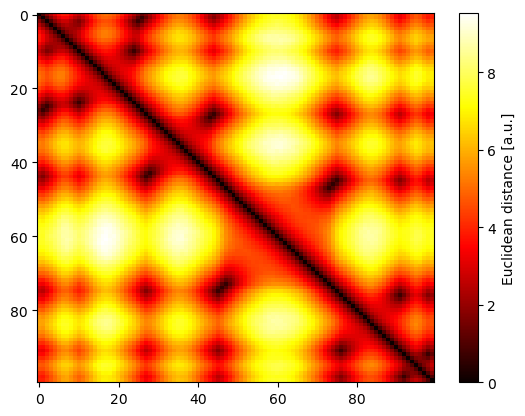

In [65]:
visualize_dmap(np.median(esc_dmaps, axis=2), save_path=os.path.join(save_dir, 'esc_sim_dmap.png'))

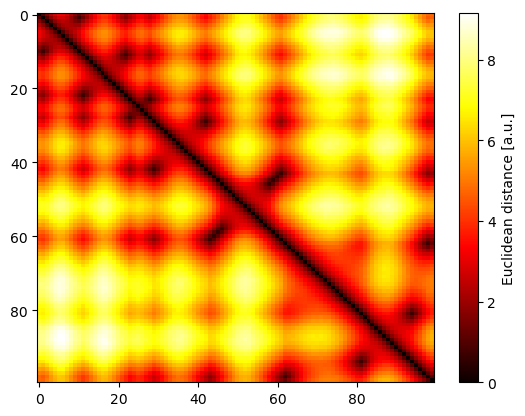

In [66]:
visualize_dmap(np.median(cnc_dmaps, axis=2), save_path=os.path.join(save_dir, 'cnc_sim_dmap.png'))

In [37]:
contact_threshold = np.mean(np.diagonal(np.mean(esc_dmaps, axis=2), 1))

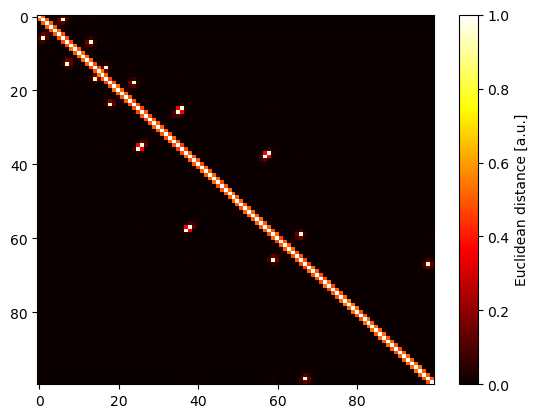

In [38]:
visualize_dmap(np.mean(esc_dmaps < contact_threshold, axis=2))

In [67]:
esc_dmaps_flatten = [esc_dmaps[:, :, i].flatten() for i in range(esc_dmaps.shape[2])]
cnc_dmaps_flatten = [cnc_dmaps[:, :, i].flatten() for i in range(cnc_dmaps.shape[2])]
all_dmaps_flatten = np.vstack([esc_dmaps_flatten, cnc_dmaps_flatten])

In [50]:
all_dmaps_flatten.shape

(2000, 10000)

In [15]:
# umap the distance maps 
from umap import UMAP

In [68]:
umap = UMAP(n_components=2)
umap_embeddings = umap.fit(all_dmaps_flatten)

In [69]:
esc_umap = umap_embeddings.transform(esc_dmaps_flatten)
cnc_umap = umap_embeddings.transform(cnc_dmaps_flatten)

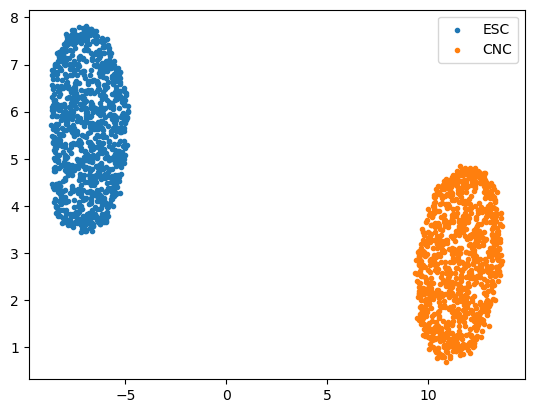

In [70]:
# plot the umap embeddings
plt.scatter(esc_umap[:, 0], esc_umap[:, 1], marker='.', label='ESC')
plt.scatter(cnc_umap[:, 0], cnc_umap[:, 1], marker='.', label='CNC')
plt.legend()
plt.savefig(os.path.join(save_dir, 'umap_embeddings_all_sim.png'), dpi=300, bbox_inches='tight')

In [71]:
esc_pd = pd.DataFrame(esc_umap, columns=['UMAP1', 'UMAP2'])
esc_pd = esc_pd.assign(label='ESC')
cnc_pd = pd.DataFrame(cnc_umap, columns=['UMAP1', 'UMAP2'])
cnc_pd = cnc_pd.assign(label='CNC')
all_pd = pd.concat([esc_pd, cnc_pd])

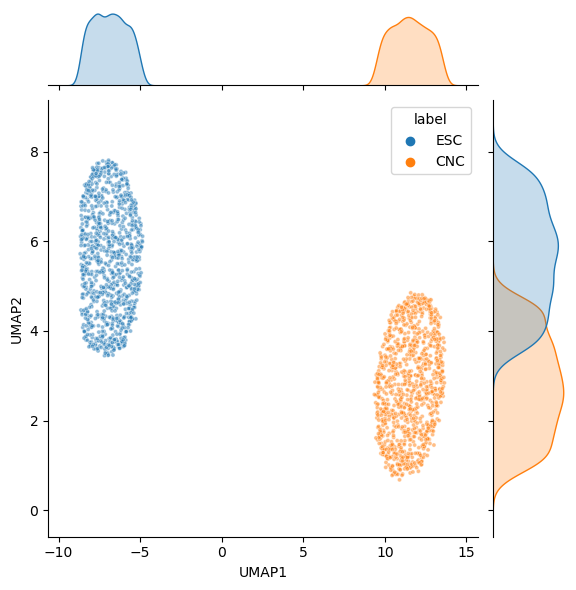

In [72]:
sns.jointplot(data=all_pd, x='UMAP1', y='UMAP2', hue='label', alpha=0.5, marker='.')
plt.savefig(os.path.join(save_dir, 'umap_embeddings_all_sim.png'), dpi=300, bbox_inches='tight')

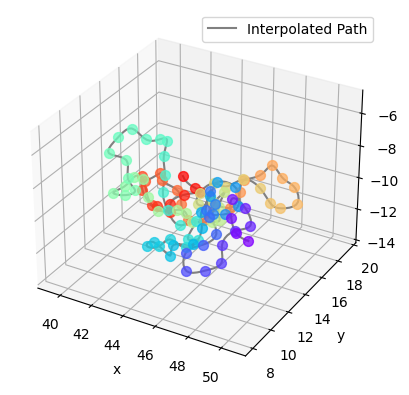

In [46]:
visualize_polymer(esc_polys[:, :, 6])